<a href="https://colab.research.google.com/github/MahdiEsrafili/image_segmentation/blob/dev/cancer_instance_segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# !wget https://warwick.ac.uk/fac/sci/dcs/research/tia/data/hovernet/consep.zip
# !unzip -q consep.zip -d consep
# import scipy.io
# mat = scipy.io.loadmat('consep/CoNSeP/Train/Labels/train_1.mat')
# np.unique(mat['type_map'])
# img = cv2.imread('consep/CoNSeP/Train/Images/train_1.png')
# img.shape
# plt.figure(figsize=(10,5))
# plt.subplot(1,2,1)
# plt.imshow(mat['type_map'])
# plt.subplot(1,2,2)
# plt.imshow(img)

--2021-02-18 14:17:30--  https://warwick.ac.uk/fac/sci/dcs/research/tia/data/hovernet/consep.zip
Resolving warwick.ac.uk (warwick.ac.uk)... 137.205.28.41
Connecting to warwick.ac.uk (warwick.ac.uk)|137.205.28.41|:443... connected.
HTTP request sent, awaiting response... 200 
Length: 153334740 (146M) [application/zip]
Saving to: ‘consep.zip’

consep.zip          100%[===================>] 146.23M  15.8MB/s    in 10s     

2021-02-18 14:17:41 (14.0 MB/s) - ‘consep.zip’ saved [153334740/153334740]



In [ ]:
!wget https://warwick.ac.uk/fac/sci/dcs/research/tia/data/pannuke/fold_2.zip

--2021-02-20 06:41:30--  https://warwick.ac.uk/fac/sci/dcs/research/tia/data/pannuke/fold_2.zip
Resolving warwick.ac.uk (warwick.ac.uk)... 137.205.28.41
Connecting to warwick.ac.uk (warwick.ac.uk)|137.205.28.41|:443... connected.
HTTP request sent, awaiting response... 200 
Length: 658842552 (628M) [application/zip]
Saving to: ‘fold_2.zip’

fold_2.zip          100%[===================>] 628.32M  12.9MB/s    in 46s     

2021-02-20 06:42:16 (13.8 MB/s) - ‘fold_2.zip’ saved [658842552/658842552]



In [ ]:
!unzip -q fold_2.zip -d panuka/

In [ ]:
!cp drive/MyDrive/torchv.zip ./
!unzip torchv.zip 
!cp -a torchv/. ./

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from torch.utils.data import Dataset, DataLoader
import torch, torchvision
import torchvision.transforms as T
import os
from tqdm.notebook import trange
from PIL import Image

In [2]:
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor
from engine import train_one_epoch, evaluate
import utils

In [3]:
masks = np.load('panuka/Fold 2/masks/fold2/masks.npy', mmap_mode='r')
images = np.load('panuka/Fold 2/images/fold2/images.npy', mmap_mode='r')
types = np.load('panuka/Fold 2/images/fold2/types.npy', mmap_mode='r')

In [4]:
channel_types = np.array(['Neoplastic cells', 'Inflammatory', 'Connective/Soft tissue cells', 'Dead Cells', 'Epithelial', 'Background'])

In [5]:
tissue_types, freq = np.unique(types, return_counts=True)
tissue_types, freq

(array(['Adrenal_gland', 'Bile-duct', 'Bladder', 'Breast', 'Cervix',
        'Colon', 'Esophagus', 'HeadNeck', 'Kidney', 'Liver', 'Lung',
        'Ovarian', 'Pancreatic', 'Prostate', 'Skin', 'Stomach', 'Testis',
        'Thyroid', 'Uterus'], dtype='<U13'),
 array([148, 103,  61, 749,  52, 468, 128, 169,  56,  66,  53,  40,  89,
         37,  87,  48,  79,  84,   6]))

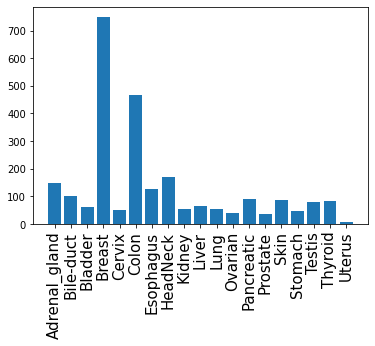

In [6]:
plt.bar(tissue_types, freq)
plt.xticks(rotation = 90, fontsize=15)
plt.show()

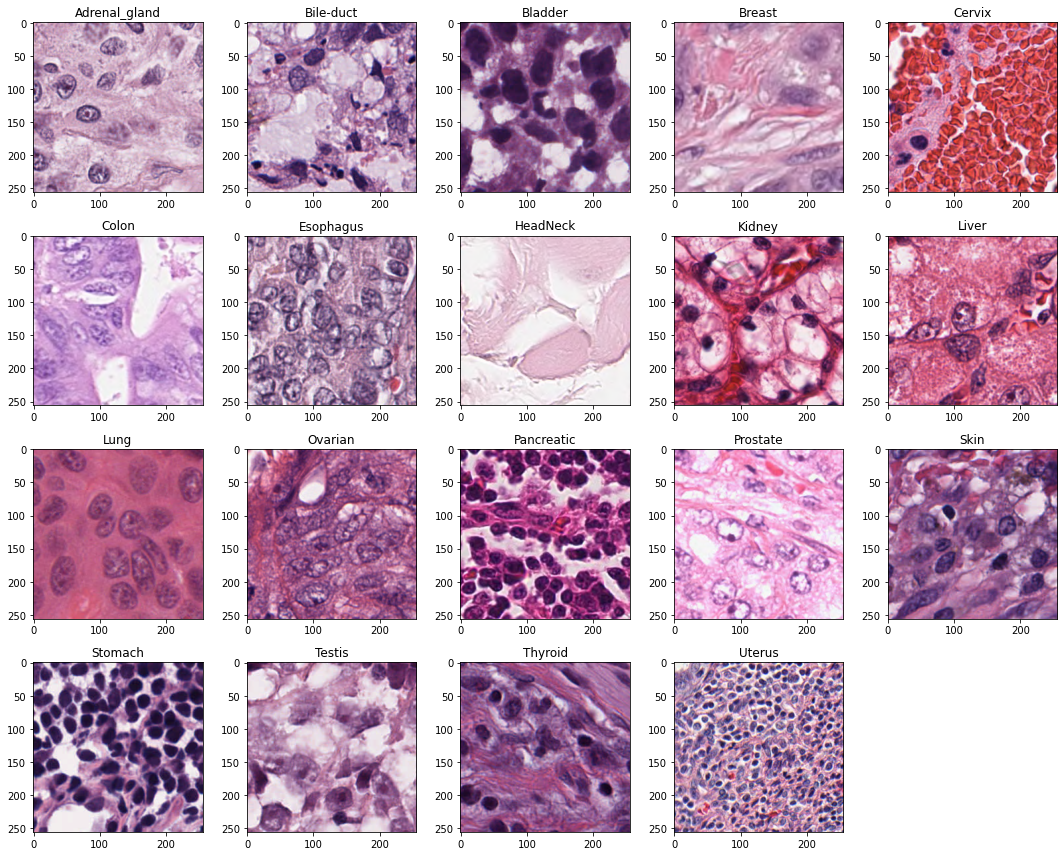

In [7]:
plt.figure(figsize=(15, 12))
for i, t in enumerate(tissue_types):
  idx = np.where(types==t)[0][np.random.randint(0, 5)]
  plt.subplot(4, 5, i+1)
  plt.imshow(images[idx].astype(np.uint8))
  plt.title(t)

plt.tight_layout()
plt.show()

In [8]:
cell_count_channels = {t:{i:0 for i in range(6)} for t in tissue_types}
pbar = trange(masks.shape[0])
for t in tissue_types:
  ids = np.where(types==t)[0]
  for id in ids:
    for c in range(6):
      counts = np.unique(masks[id, :, :, c]).shape[0]
      cell_count_channels[t][c] += counts
    pbar.update(1)

In [56]:
import pickle
with open('cell_count_channels.pkl', 'wb') as f:
  pickle.dump(cell_count_channels,f)

!cp cell_count_channels.pkl drive/MyDrive/cancer_instance_segmentation/

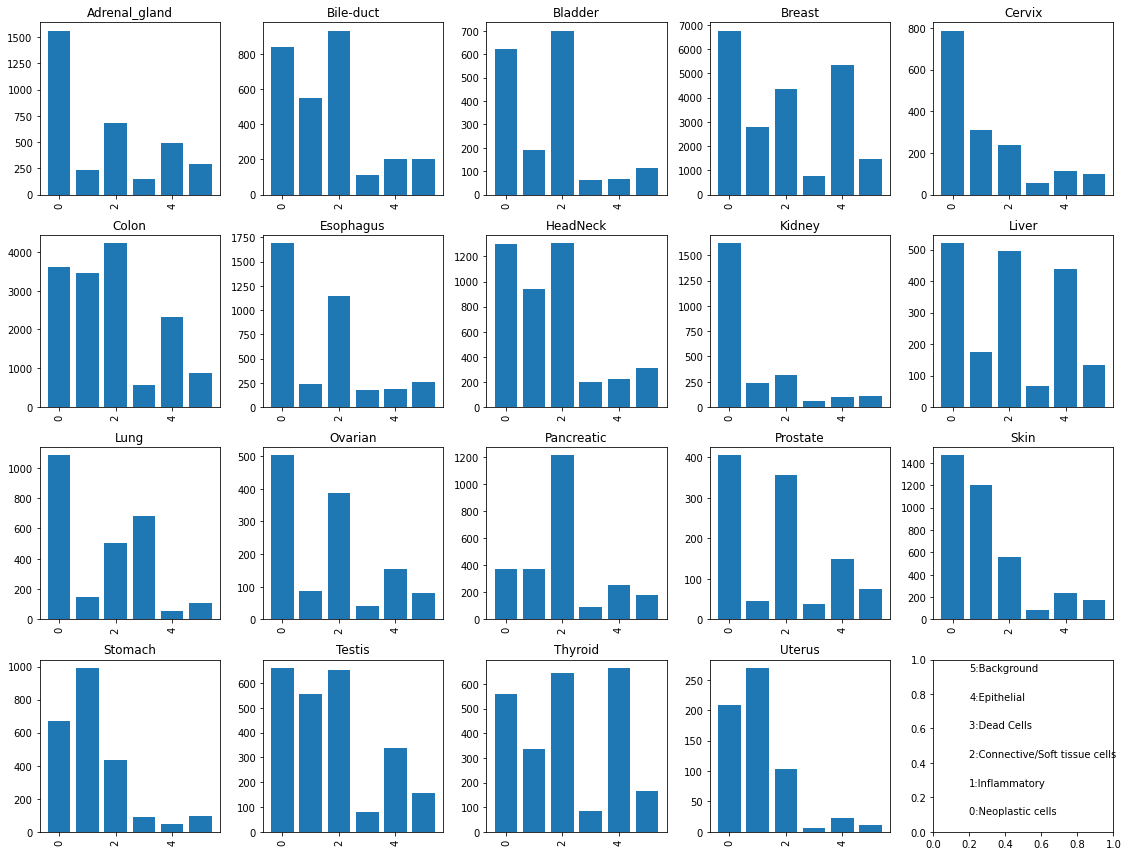

In [9]:
plt.figure(figsize=(16,12))
for i,t in enumerate(cell_count_channels):
  plt.subplot(4,5, i+1)
  plt.bar(cell_count_channels[t].keys(), cell_count_channels[t].values())
  plt.xticks(rotation=90)
  plt.title(t)

plt.subplot(4,5,20)
for i,c in enumerate(channel_types):
  plt.text(0.2, 0.10+ i/6, f'{i}:{c}')

plt.tight_layout()

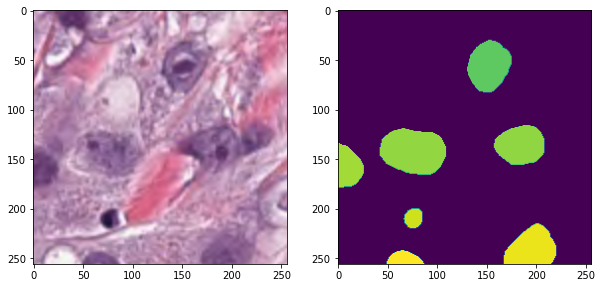

In [10]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.imshow(images[10].astype(np.uint8))
plt.subplot(1,2,2)
plt.imshow(masks[10,:,:,0].astype(np.uint8))

In [11]:
np.unique(masks[10,:,:,0])

array([  0., 103., 114., 115., 118., 127., 133., 137.])

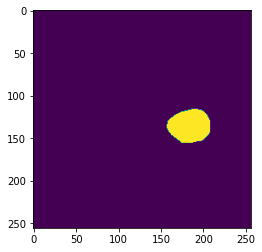

In [12]:
plt.imshow(masks[10,:,:,0]==114.0)

In [94]:
class CancerDS(Dataset):
  def __init__(self,indexes, images, masks, types, transform):
    self.indexes = indexes
    self.images = images
    self.masks = masks
    self.types = types
    self.transform = transform

  def __len__(self):
    return self.indexes.shape[0]

  def __getitem__(self, idx):
    image = Image.fromarray(self.images[self.indexes[idx]].astype(np.uint8))
    image = self.transform(image)
    mask = self.masks[idx]
    bboxes, bbox_labels, bbox_areas, masks = self.create_bbox(mask)
    iscrowd = torch.tensor([False for _ in range(bboxes.shape[0])]) 
    target = {'boxes':bboxes, 'labels':bbox_labels, 'image_id':torch.tensor([idx]),
              'area':bbox_areas, 'iscrowd':iscrowd, 'masks':masks}
    return image, target
  def create_bbox(self, mask):
    channel_types = np.array(['Neoplastic cells', 'Inflammatory', 'Connective/Soft tissue cells', 'Dead Cells', 'Epithelial', 'Background'])
    result = mask.copy()
    bboxes = []
    bbox_labels = []
    bbox_areas = []
    masks = []
    num_channels = result.shape[-1]
    channel_label_map = {0:5, 1:1, 2:2, 3:3, 4:4, 5:0}
    for channel in range(num_channels):
      unique_objs = np.unique(result[:,:,channel])
      for obj in unique_objs:
        rows, columns = np.where(result[:,:,channel]==obj)
        # if len(rows) == 1:
        #   rows = (rows[0], rows[0]+2)
        # if len(columns) == 1:
        #   columns = (columns[0], columns[0]+2)
        # print(rows.max(), rows.min(), columns.max(), columns.min())
        if (rows.min() == rows.max()) or (columns.min() == columns.max()):
          continue
        if ((rows.min() == 0) and (rows.max() ==255)) or ((columns.min() == 0) and (columns.max() ==255)):
          continue

        bboxes.append([columns.min(), rows.min(), columns.max(), rows.max()])
        bbox_labels.append(channel_label_map[channel])
        area = (rows.max() - rows.min()) * (columns.max() - columns.min())
        bbox_areas.append(area)
        m =(result[:,:,channel] == obj)*result[:,:,channel]
        masks.append(m)
    bboxes = torch.tensor(bboxes, dtype=torch.int64)
    bbox_labels = torch.tensor(bbox_labels, dtype=torch.int64)
    bbox_areas = torch.tensor(bbox_areas, dtype=torch.float32)
    masks = torch.tensor(masks, dtype=torch.int8)
    return bboxes, bbox_labels, bbox_areas, masks


In [95]:
transform = T.Compose([T.ToTensor()])

In [96]:
breast_cell_idx = np.where(types=='Breast')[0]

In [97]:
train_ds = CancerDS(breast_cell_idx, images, masks, types, transform)

In [98]:
train_ds[1][1]

{'area': tensor([1887.,  528.,  704., 1056.,  504., 1683., 1188.,  837., 3503.]),
 'boxes': tensor([[  0, 218,  51, 255],
         [233,   2, 255,  26],
         [101,  13, 133,  35],
         [ 39,  24,  87,  46],
         [207,  27, 231,  48],
         [120,  79, 171, 112],
         [ 11,  82,  47, 115],
         [213, 125, 240, 156],
         [ 40,  49, 153,  80]]),
 'image_id': tensor([1]),
 'iscrowd': tensor([False, False, False, False, False, False, False, False, False]),
 'labels': tensor([5, 2, 2, 2, 2, 2, 2, 2, 2]),
 'masks': tensor([[[  0,   0,   0,  ...,   0,   0,   0],
          [  0,   0,   0,  ...,   0,   0,   0],
          [  0,   0,   0,  ...,   0,   0,   0],
          ...,
          [  0, 126, 126,  ...,   0,   0,   0],
          [  0,   0, 126,  ...,   0,   0,   0],
          [  0,   0,   0,  ...,   0,   0,   0]],
 
         [[  0,   0,   0,  ...,   0,   0,   0],
          [  0,   0,   0,  ...,   0,   0,   0],
          [  0,   0,   0,  ...,  88,  88,  88],
          

In [99]:
batch_size = 4
train_loader = DataLoader(train_ds, batch_size, collate_fn=utils.collate_fn)

In [100]:
def get_model_instance_segmentation(num_classes=6):
    # load an instance segmentation model pre-trained pre-trained on COCO
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)

    # get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    # now get the number of input features for the mask classifier
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    # and replace the mask predictor with a new one
    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask,
                                                       hidden_layer,
                                                       num_classes)

    return model

In [101]:
model = get_model_instance_segmentation(num_classes=6)

# move model to the right device
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                            momentum=0.9, weight_decay=0.0005)
# and a learning rate scheduler
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                                step_size=3,
                                                gamma=0.1)

# let's train it for 10 epochs
num_epochs = 10

for epoch in range(num_epochs):
    # train for one epoch, printing every 10 iterations
    train_one_epoch(model, optimizer, train_loader, device, epoch, print_freq=10)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
    # evaluate(model, data_loader_test, device=device)

print("That's it!")

[{'boxes': tensor([[ 77,   0, 112,  11],
        [190,  18, 234,  58],
        [  0,  94,  14, 136],
        [163,  98, 221, 127],
        [237, 218, 255, 251],
        [206, 221, 238, 255],
        [167, 183, 248, 215],
        [  3, 185,  45, 208],
        [114, 238, 157, 255]]), 'labels': tensor([5, 5, 5, 5, 5, 5, 2, 2, 2]), 'image_id': tensor([0]), 'area': tensor([ 385., 1760.,  588., 1682.,  594., 1088., 2592.,  966.,  731.]), 'iscrowd': tensor([False, False, False, False, False, False, False, False, False]), 'masks': tensor([[[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]],

        [[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]],

        [[0, 0, 0, 

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3103: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "


Epoch: [0]  [  0/188]  eta: 4:19:12  lr: 0.000032  loss: 117.9470 (117.9470)  loss_classifier: 1.6302 (1.6302)  loss_box_reg: 0.4478 (0.4478)  loss_mask: 114.7320 (114.7320)  loss_objectness: 1.0901 (1.0901)  loss_rpn_box_reg: 0.0468 (0.0468)  time: 82.7244  data: 0.3890
[{'boxes': tensor([[  0,  53,  50, 101],
        [ 86, 194, 113, 221],
        [252, 238, 255, 255],
        [  1, 233,  61, 255],
        [153, 233, 180, 255],
        [174,  94, 195, 130],
        [133,  95, 154, 143]]), 'labels': tensor([5, 5, 5, 5, 5, 2, 2]), 'image_id': tensor([4]), 'area': tensor([2400.,  729.,   51., 1320.,  594.,  756., 1008.]), 'iscrowd': tensor([False, False, False, False, False, False, False]), 'masks': tensor([[[ 0,  0,  0,  ...,  0,  0,  0],
         [ 0,  0,  0,  ...,  0,  0,  0],
         [ 0,  0,  0,  ...,  0,  0,  0],
         ...,
         [ 0,  0,  0,  ...,  0,  0,  0],
         [ 0,  0,  0,  ...,  0,  0,  0],
         [ 0,  0,  0,  ...,  0,  0,  0]],

        [[ 0,  0,  0,  ...,  0,

SystemExit: ignored

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2890: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [107]:
with torch.no_grad():
  model.eval()
  img = train_ds[100][0].unsqueeze(0)
  r = model(img)

RuntimeError: ignored